# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [30]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [31]:
cat_features_values = {'experience_level': ['SE', 'MI', 'EN', 'EX'],
                'employment_type': ['FT', 'PT', 'CT', 'FL'],
                'remote_ratio': [0, 50, 100],
                'company_size': ['S', 'M', 'L']}

def check_values(df, values):
  for k, v in values.items():
    if not df[k].isin(v).all():
      print('В столбце {} есть недопустимые значения'.format(k))
    else:
      print('В столбце {} все значения допустимые'.format(k))

check_values(df, cat_features_values)

В столбце experience_level все значения допустимые
В столбце employment_type все значения допустимые
В столбце remote_ratio все значения допустимые
В столбце company_size все значения допустимые


## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [32]:
df.dtypes

,0
work_year,int64
experience_level,object
employment_type,object
job_title,object
salary,int64
salary_currency,object
salary_in_usd,int64
employee_residence,object
remote_ratio,int64
company_location,object


Типы данные корректны, соответствуют сути показателей.

In [33]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [34]:
df.describe(include='object')

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,3755,3755,3755,3755,3755,3755,3755
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,2516,3718,1040,3224,3004,3040,3153


In [35]:
df.duplicated().sum()

1171

В датасете имеется 1171 дубликат. Причинами появления дубликатов могут быть:
1. Поиск сотрудников на схожую позицию в разные подразделения (например Python-девелопер может быть нужен и в операционный блок и в финансовый)
2. В выборку попала одна и та же вакансия, но из разных источников.  

Для дальнейшей работы удалим все дубликаты.

In [36]:
df.drop_duplicates(inplace=True)

In [37]:
df.isnull().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


Пропуски в данных отсутствуют.

Проанализируем распределения и оценим наличие выбросов.

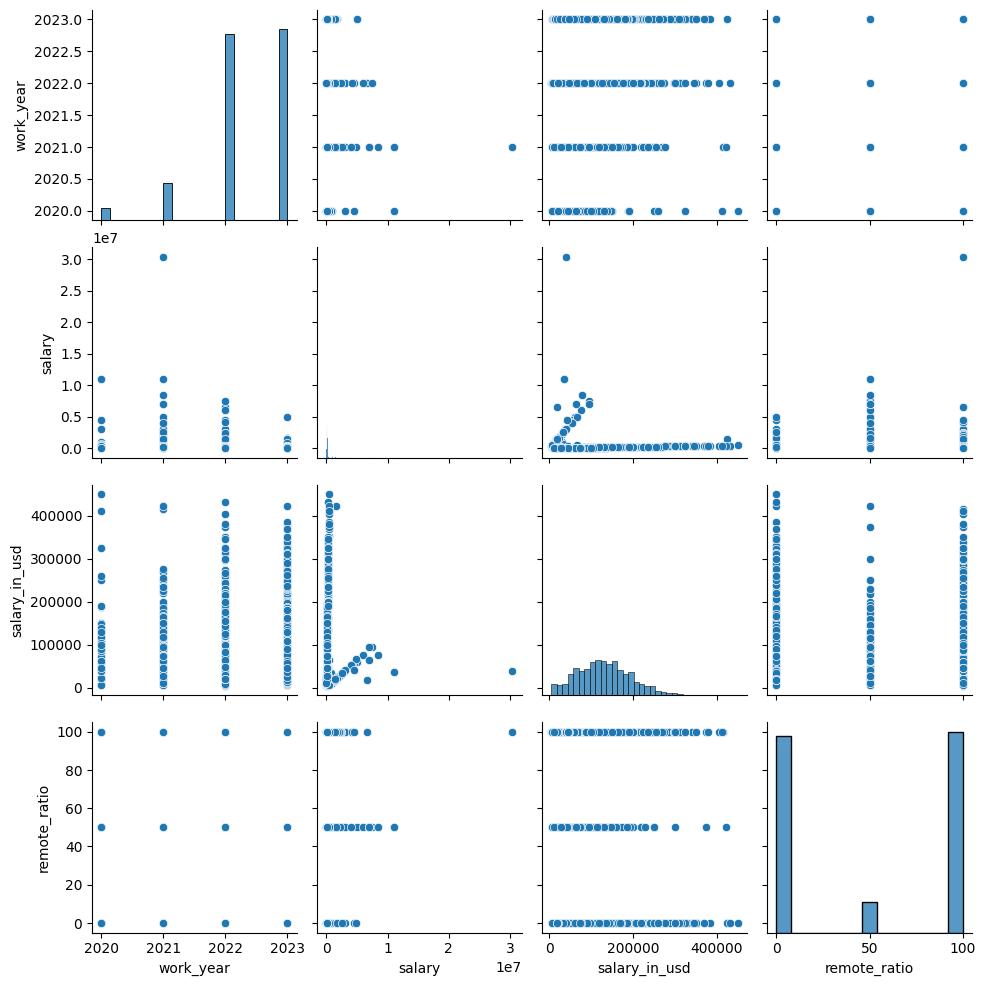

In [38]:
sns.pairplot(df)

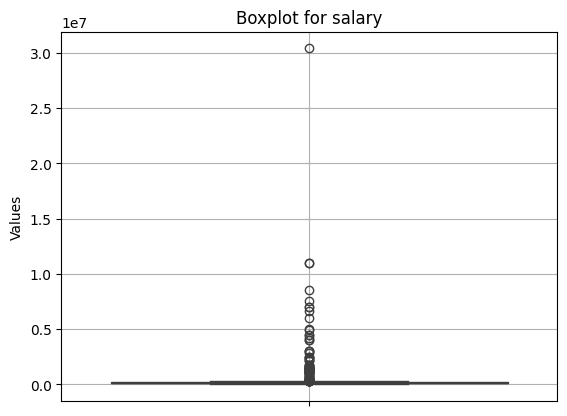

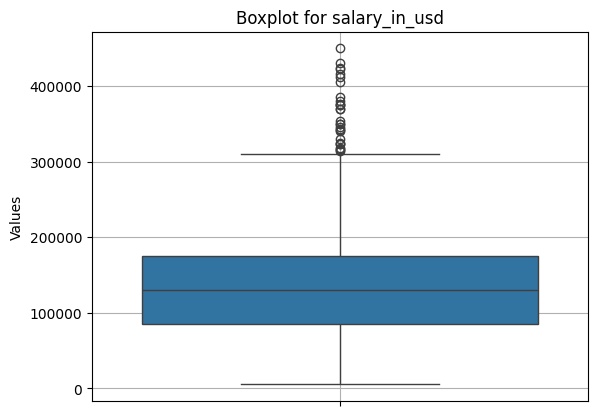

In [39]:
numeric_cols = ['salary', 'salary_in_usd']

for column in numeric_cols:
    sns.boxplot(data=df[column])
    plt.title(f'Boxplot for {column}')
    plt.ylabel('Values')
    plt.grid()
    plt.show()

In [40]:
df.salary_currency.value_counts().head(10)

,count
salary_currency,
USD,2107
EUR,200
GBP,144
INR,59
CAD,25
AUD,9
SGD,6
BRL,6
PLN,5


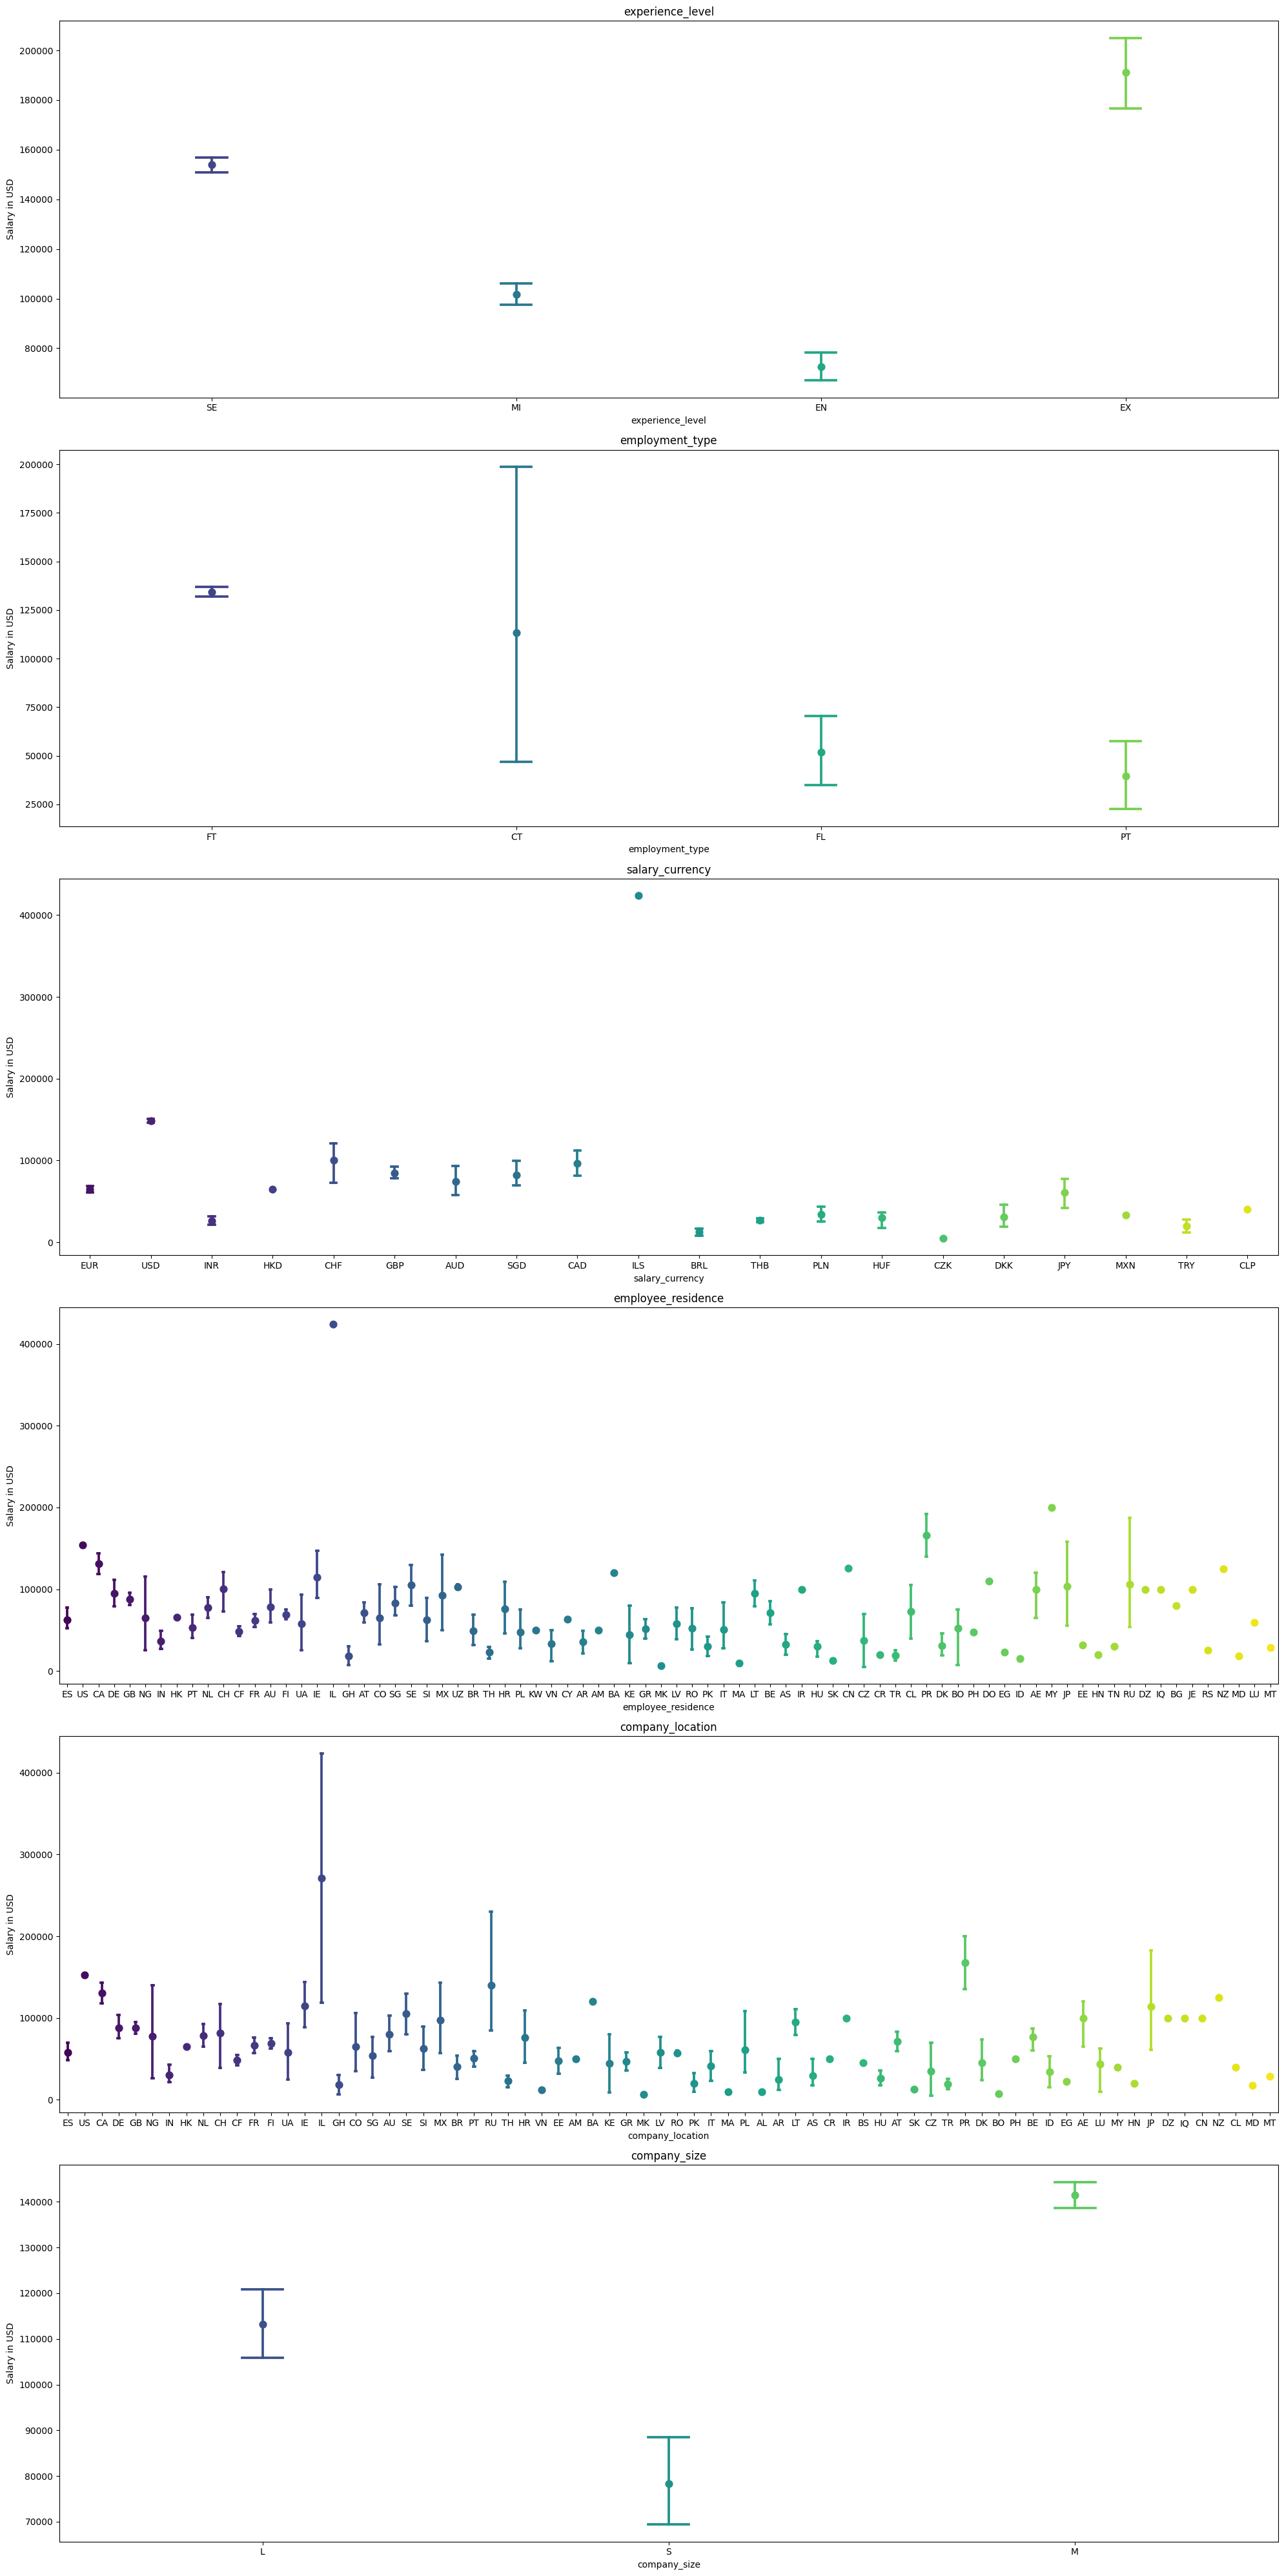

In [41]:
plt.figure(figsize=(20, 40))

cat_cols = df.select_dtypes(include='object').drop('job_title', axis=1).columns

for i, column in enumerate(cat_cols):
    plt.subplot(len(cat_cols), 1, i + 1)
    sns.pointplot(data=df, x=column, y='salary_in_usd', hue=column, palette='viridis', markers='o', capsize=0.1, legend=False)
    plt.title(f'{column}')
    plt.ylabel('Salary in USD')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

In [42]:
df.groupby(['employee_residence'])[['salary_in_usd']].median().sort_values(by='salary_in_usd', ascending=False)

,salary_in_usd
employee_residence,
IL,423834.0
MY,200000.0
PR,160000.0
US,147000.0
CN,125404.0
...,...
MD,18000.0
ID,15000.0
SK,12608.0


In [43]:
df.company_size.value_counts()

,count
company_size,
M,2028
L,409
S,147


In [44]:
df.groupby(['company_size', 'experience_level'])['experience_level'].count()

company_size  experience_level
L             EN                    96
              EX                    13
              MI                   132
              SE                   168
M             EN                   125
              EX                    77
              MI                   483
              SE                  1343
S             EN                    49
              EX                     6
              MI                    49
              SE                    43
Name: experience_level, dtype: int64

In [45]:
df.groupby(['job_title'])[['salary_in_usd']].median().sort_values(by='salary_in_usd', ascending=False)

,salary_in_usd
job_title,
Data Science Tech Lead,375000.0
Cloud Data Architect,250000.0
Data Lead,212500.0
Data Analytics Lead,211254.5
Head of Data,202500.0
...,...
Product Data Analyst,20000.0
Staff Data Analyst,15000.0
3D Computer Vision Researcher,15000.0


**Выводы:**
1. Имеются существенные выбросы по зарплате. В целом, учитывая что мы в данной ДЗ используем алгоритмы на основе решающих деревьев, дополнительная обработка выбросов не требуется.
2. Зарплата в USD офисе будет выше, чем на удаленке. В целом логично, поскольку на удаленную работу можно нанять сотрудников в странах и регионах с более низкой з/п. В офис же придется искать сотрудника, находящегося в городе присутствия компании (как правило это крупные города с дорогой рабочей силой).
3. График salary - salary_in_usd может показаться странным (похож на стрелки часов), однако это объяснимо тем, что salary в разных валютах с разными курсами конвертации.
4. Доля вакансий с гибридным графиков достаточно низкая относительно удаленки / офиса.
5. Зависимость средней зарплаты от уровня опыта в целом логична: executive получают больше всех, далее senior, middle, entry level. При этом также заметно, что диапазон зарплаты на executive уровне существенно шире, чем на остальных.
6. В части типа заняточти ситуация логичная: фулл-тайм выше парт-тайм, при этом диапазон зарплаты на контрактной занятости (CL) существенно шире, чем на остальных типах занятости. При контрактном типе котором работник нанимается на определенный срок или для выполнения конкретного проекта. Условия труда и оплата могут варьироваться в зависимости от контракта. Диапазоны для фриланса и частичной занятости выше, чем для фулл-тайма.
7. С точки зрения страны резиденства работника вероятно есть корреляция с общим уровнем экономического благополучия страны. Например, самые низкие медианные зарплаты в Македонии, Марокко, Индонезии, Молдове. Самые высокие - США, Израиль, Китай, Малайзия.
8. Интересно, что в компаниях маленького размера средние зарплаты значительно выше, чем среднего и большого. При этом компании нанимают меньше seniors и executives. Это может происходить по нескольким причинам:
* маленьким компаниям, чтобы конкурировать за сильные кадры, приходится делать выше премию к рынку
* в маленьких компаниях может быть хуже соц.пакет, поэтому его отсутствие может компенсироваться более высокой зарплатой
* в маленьких компаниях может быть меньше возможностей для карьерного роста, чем в компаниях с большим штатом, что может быть компенсировано большей вариативностью зарплат.
9. С точки зрения job_title всё ожидаемо. В топ-5 вакансий по зарплатам - лиды и архитекты, в боттоме - рядовые аналитики данных.

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

In [46]:
ct = pd.crosstab(df['salary_currency'], df['employee_residence'])

chi2, p, dof, ex = stats.chi2_contingency(ct)

print(f'chi2: {chi2:.1f}')
print(f'p-value: {p:.3f}')

chi2: 33687.6
p-value: 0.000


In [47]:
def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    phi2corr = max(0, phi2 - (k - 1) * (r - 1) / (n - 1))
    rcorr = r - (r - 1) ** 2 / (n - 1)
    kcorr = k - (k - 1) ** 2 / (n - 1)

    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

cramers_v = cramers_v(ct.values)
print(f'Коэффициент Крамера: {cramers_v:.2f}')

Коэффициент Крамера: 0.81


In [48]:
ct = pd.crosstab(df['company_location'], df['employee_residence'])

chi2, p, dof, ex = stats.chi2_contingency(ct)

print(f'chi2: {chi2:.1f}')
print(f'p-value: {p:.3f}')

chi2: 140113.3
p-value: 0.000


In [49]:
def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    phi2corr = max(0, phi2 - (k - 1) * (r - 1) / (n - 1))
    rcorr = r - (r - 1) ** 2 / (n - 1)
    kcorr = k - (k - 1) ** 2 / (n - 1)

    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

cramers_v = cramers_v(ct.values)
print(f'Коэффициент Крамера: {cramers_v:.2f}')

Коэффициент Крамера: 0.87


In [50]:
df.work_year.value_counts()

,count
work_year,
2023,1156
2022,1125
2021,228
2020,75


In [51]:
df.groupby(['work_year', 'experience_level'])['salary_in_usd'].mean()

work_year  experience_level
2020       EN                   59512.454545
           EX                  139944.333333
           MI                   87564.718750
           SE                  137240.500000
2021       EN                   54905.254545
           EX                  186128.000000
           MI                   80711.377778
           SE                  126085.356164
2022       EN                   69949.945455
           EX                  183837.743590
           MI                   99578.621528
           SE                  149572.658430
2023       EN                   91464.915663
           EX                  202107.340909
           MI                  113659.740157
           SE                  160743.310968
Name: salary_in_usd, dtype: float64

**Выводы:**
1. Переменная salary в нац. валюте является лишней, поскольку разброс зарплаты в нац. валютах будет достаточно большой и малоинформативный.
2. Между переменными salary_currency и employee_residence есть статистически значимая корреляция. Переменная salary_currency может быть удалена.
3. Также сильно скоррелированы employee_residence и company_location. Считаю целесообразным оставить только employee_residence.
4. Много категорий в следующих признаках: employee_residence, salary_currency, company_location
5. Данные взяты за период 2020-2023, при этом 88% данных приходится на 2022-2023 год. Уровень зарплаты между годами может отличаться, учитывая инфляцию, разную конъюнктуру рынка. Однако в целом, данный признак не несет смысловой нагрузки с т.з. прогнозирования - искать работу "в прошлом" все равно возможности нет. Поэтому столбец work_year был удален.

In [52]:
df.drop(['salary_currency', 'company_location', 'work_year'], axis=1, inplace=True)

In [53]:
df.head()

,experience_level,employment_type,job_title,salary,salary_in_usd,employee_residence,remote_ratio,company_size
0,SE,FT,Principal Data Scientist,80000,85847,ES,100,L
1,MI,CT,ML Engineer,30000,30000,US,100,S
2,MI,CT,ML Engineer,25500,25500,US,100,S
3,SE,FT,Data Scientist,175000,175000,CA,100,M
4,SE,FT,Data Scientist,120000,120000,CA,100,M


## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [ ]:
# Ваш код здесь

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [ ]:
# Ваш код здесь

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [ ]:
# Ваш код здесь

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [ ]:
# Ваш код здесь

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [ ]:
# Ваш код здесь

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [ ]:
# Ваш код здесь

**Ваш ответ здесь**.

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

In [ ]:
# Ваш код здесь

**Ваш ответ здесь**.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
# Ваш код здесь
X =
y =

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
# Ваш код здесь
scaler =
X_scaled =

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
# Ваш код здесь
pca =
X_pca =

### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

In [ ]:
# Ваш код здесь
plt.scatter()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
# Ваш код здесь

### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

In [ ]:
# Ваш код здесь

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш вывод здесь**

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

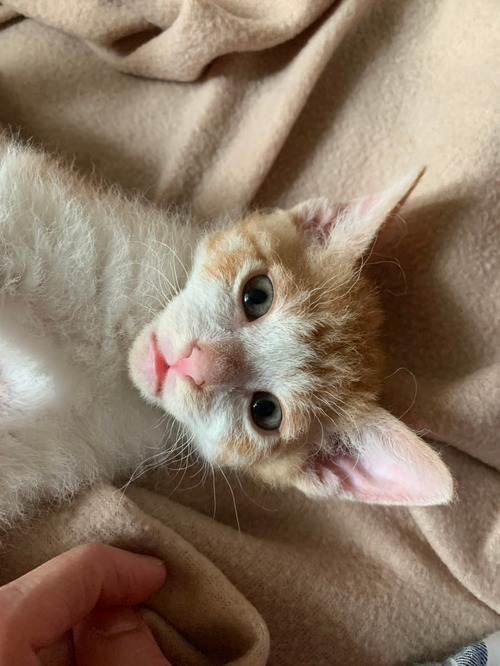